# Imports & basic configuration

In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch import Net
from galerkin import DGMNet
from bsde import BSDENet
import logging
from pynverse import inversefunc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.11.0+cu113
torchaudio version: 0.11.0+cu113
torchvision version: 0.12.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Tue May 10 16:55:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
| 34%   55C    P8    40W / 350W |    123MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    **kwargs,
):
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)

    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "log/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "log/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "log/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

# Generalized burgers equation

In [5]:
def gen_fun_and_inv(n, eps, nu, u1, u2):
    if n <= 1/4 and (1/n) % 1 == 0:
        print("Infinity detected when calculating hypergeometric function, the calculation is not accurate!")
    if n == 1:
        fun = (
            lambda u:(
                2*nu/(u2-u1)*np.log((u2 - u)/(u - u1))
            )
        )
    elif n == 1/2:
        fun = (
            lambda u: (
                (2*nu)**2*(
                    (u2-u1)**(-2)*(1/(u-u1) - 1/(u2-u))
                    + 2*(u2-u1)**(-3)*np.log((u2-u)/(u-u1)))
            )
        )
    elif n == 1/3:
        fun = (
            lambda u: (
                (2*nu)**3*(
                    .5*(u2-u1)**(-3)*(1/(u-u1)**2 - 1/(u2-u)**2)
                    + 3*(u2-u1)**(-4)*(1/(u-u1) - 1/(u2-u))
                    + 6*(u2-u1)**(-5)*np.log((u2-u)/(u-u1)))
            )
        )
    else:
        fun = (lambda u:-(2*nu)**(1/n)*n*(u-u1)*((u2-u1)*(u-u1))**(-1/n)*special.hyp2f1(1/n,1-1/n,2-1/n, (u-u1)/(u2-u1))/(n-1))
    inv = (lambda xi: inversefunc(fun, y_values=xi, domain=[u1+eps,u2-eps]))
    return fun, inv


def gen_for_generalized_burgers(
    n=1,
    T=1.,
    u1=0.,
    u2=1.,
    nu=.5,
    eps=1e-6,
    eps_graph=1e-2,
    verbose=False
):
    neurons = 50
    nb_points = 10000
    lambd = (u1 + u2) / 2
    require_training = not(n == 1 or n == 2)
    fun, inv = gen_fun_and_inv(n=n, eps=eps, nu=nu, u1=u1, u2=u2)
    
    if require_training:
        # neural network parameter
        inv_model = torch.nn.Sequential(
            torch.nn.BatchNorm1d(1, device=device),
            torch.nn.Linear(1, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, 1, device=device),
        )

        # define the functions, x, and y
        x_for_fun = np.linspace(u1, u2, nb_points + 2)[1:-1]
        x_lo, x_hi = fun(u2-eps), fun(u1+eps)
        x = np.linspace(x_lo, x_hi, nb_points)
        y = torch.tensor(inv(x), dtype=torch.get_default_dtype(), device=device)
        x = torch.tensor(x, dtype=torch.get_default_dtype(), device=device).unsqueeze(dim=-1)

        # neural network training
        optimizer = torch.optim.Adam(inv_model.parameters(), lr=1e-2)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2000, 4000, 6000, 8000], gamma=0.5)
        loss_fun = torch.nn.MSELoss()
        inv_model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            loss = loss_fun(y, inv_model(x).squeeze())
            loss.backward()
            optimizer.step()
            scheduler.step()
            if epoch % 100 == 0 and verbose:
                print(f"Epoch {epoch}, loss = {loss}")
        inv_model.eval()

        # detach all model parameters to save memory
        for p in inv_model.parameters():
            p.requires_grad = False

        if verbose:
            # plot the graph
            plt.plot(x.cpu(), inv_model(x).detach().cpu(), label="NN approximation")
            plt.plot(x.cpu(), y.cpu(), label="true inverse")
            plt.legend()
            plt.show()
            print(f"The max difference is {(y.cpu() - inv_model(x).detach().cpu().squeeze()).abs().max()}.")

    # function definition
    deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
    def f_example(y):
        """
        idx 0 -> no deriv
        idx 1 -> first deriv
        idx 2 -> second deriv
        """
        return (
            - y[0] * y[1]
            + nu * y[2] * n * y[1].abs()**(n-1) 
            - nu * y[2]
        )

    def phi_example(x):
        if n == 1:
            return u2 + (u1 - u2) / (1 + torch.exp((u1 - u2) * x[0] / (2 * nu)))
        elif n == 2:
            return u1 + (u2 - u1) * torch.sin(-x[0] / (2 * math.sqrt(2 * nu)))**2
        else:
            return inv_model(x.T).squeeze(dim=-1)

    def exact_example(t, x, T):
        xi = x[0] - lambd * (T - t)
        if n == 1:
            return u2 + (u1 - u2) / (1 + np.exp((u1 - u2) * xi / (2 * nu)))
        elif n == 2:
            return u1 + (u2 - u1) * np.sin(-xi / (2 * math.sqrt(2 * nu)))**2
        else:
            return inv(xi)

    t_lo, x_lo, x_hi = 0., -10., 10.
    # best view for waterfall, eps < eps_graph
    x_lo, x_hi = fun(u2-eps_graph) + lambd * T, fun(u1+eps_graph)
    grid = np.linspace(x_lo, x_hi, 100)
    grid_d_dim = np.expand_dims(grid, axis=0)
    grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

    true = exact_example(t_lo, grid_d_dim, T)
    terminal = exact_example(T, grid_d_dim, T)
    return grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, f_example, deriv_map, phi_example

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 10.195677042007446 seconds.


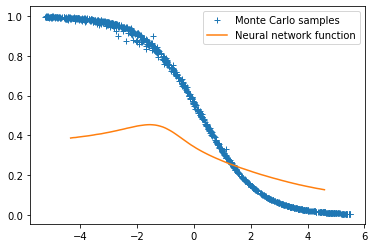

Patch 0: epoch 0 with loss 0.6747955679893494


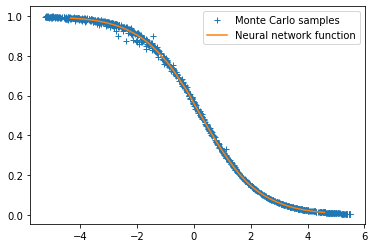

Patch 0: epoch 500 with loss 4.7384295612573624e-05


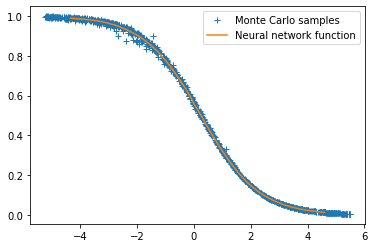

Patch 0: epoch 1000 with loss 4.698268458014354e-05


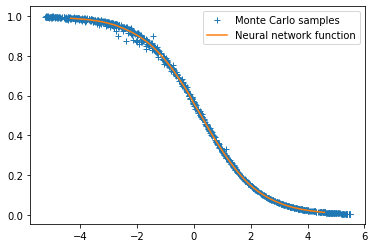

Patch 0: epoch 1500 with loss 4.690485366154462e-05


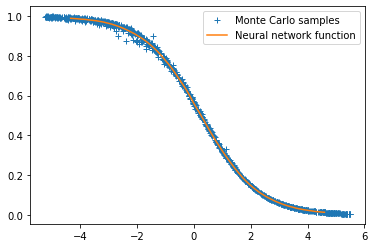

Patch 0: epoch 2000 with loss 4.6837489207973704e-05


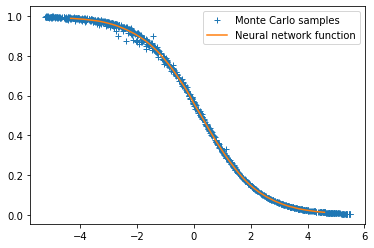

Patch 0: epoch 2500 with loss 4.689313573180698e-05


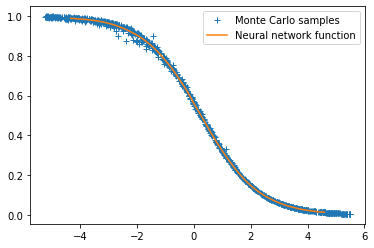

Patch 0: epoch 2999 with loss 4.68347170681227e-05
Patch 0: training of neural network with 3000 epochs take 10.256908416748047 seconds.
Time taken: 23 seconds; L1 error: 9.04E-04; L2 error: 1.28E-06; rel error: 5.08E-03.
fdb runtime: 0 seconds; total runtime: 23 seconds.




######## Summary for deep branching method
runtime:        23
fdb runtime:    0
total runtime:  23
mean L1 error:  9.04E-04
std L1 error:   0.00E+00
mean L2 error:  1.28E-06
std L2 error:   0.00E+00
mean rel error: 5.08E-03
std rel error:  0.00E+00


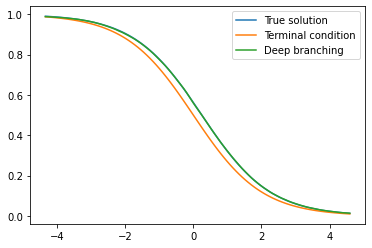

In [6]:
# n = 1
T = .5
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=1, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 10.427432298660278 seconds.


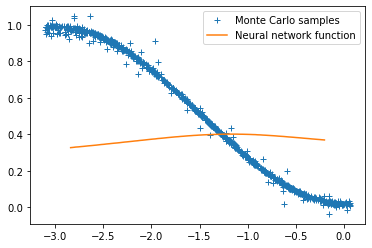

Patch 0: epoch 0 with loss 0.8191752433776855


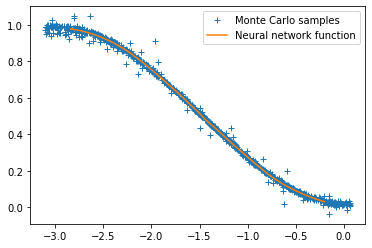

Patch 0: epoch 500 with loss 0.00019950393470935524


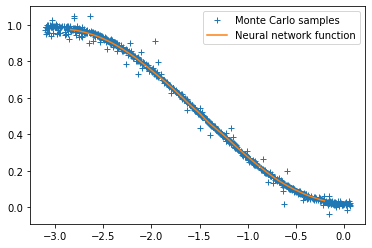

Patch 0: epoch 1000 with loss 0.00020894597400911152


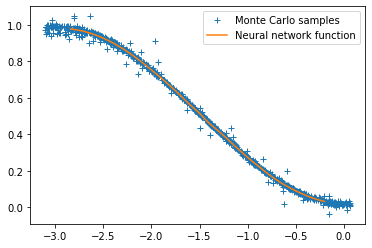

Patch 0: epoch 1500 with loss 0.00019648429588414729


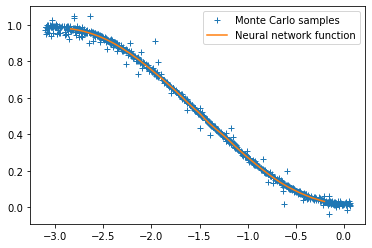

Patch 0: epoch 2000 with loss 0.00019702200370375067


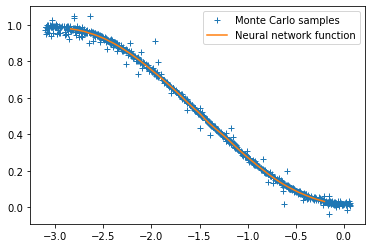

Patch 0: epoch 2500 with loss 0.00019695443916134536


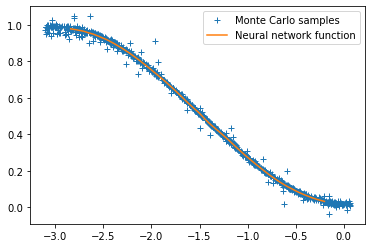

Patch 0: epoch 2999 with loss 0.00019663310376927257
Patch 0: training of neural network with 3000 epochs take 10.204036951065063 seconds.
Time taken: 21 seconds; L1 error: 2.54E-03; L2 error: 1.57E-05; rel error: 2.32E-02.
fdb runtime: 0 seconds; total runtime: 21 seconds.




######## Summary for deep branching method
runtime:        21
fdb runtime:    0
total runtime:  21
mean L1 error:  2.54E-03
std L1 error:   0.00E+00
mean L2 error:  1.57E-05
std L2 error:   0.00E+00
mean rel error: 2.32E-02
std rel error:  0.00E+00


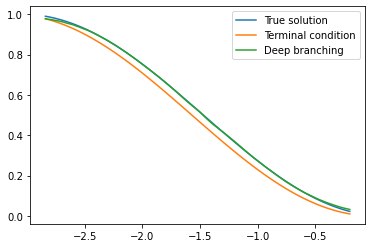

In [7]:
# n = 2
T = .2
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=2, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 22.099355697631836 seconds.


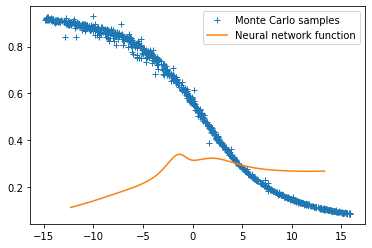

Patch 0: epoch 0 with loss 0.7738661170005798


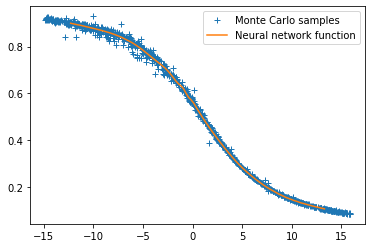

Patch 0: epoch 500 with loss 0.0001018302355078049


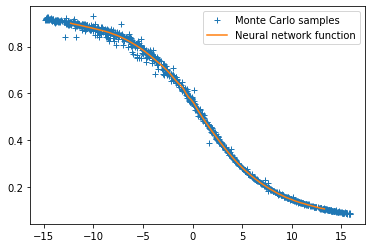

Patch 0: epoch 1000 with loss 0.00010126207052962855


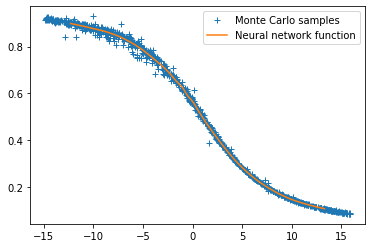

Patch 0: epoch 1500 with loss 0.0001005867961794138


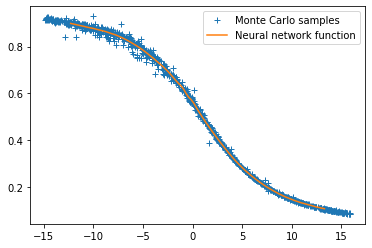

Patch 0: epoch 2000 with loss 0.00010069856216432527


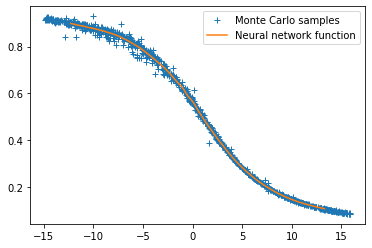

Patch 0: epoch 2500 with loss 0.00010071835276903585


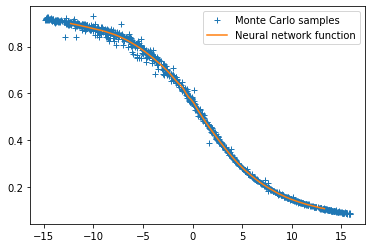

Patch 0: epoch 2999 with loss 0.00010054530866909772
Patch 0: training of neural network with 3000 epochs take 10.389865636825562 seconds.
Time taken: 32 seconds; L1 error: 1.40E-03; L2 error: 2.80E-06; rel error: 3.27E-03.
fdb runtime: 0 seconds; total runtime: 32 seconds.




######## Summary for deep branching method
runtime:        32
fdb runtime:    0
total runtime:  32
mean L1 error:  1.40E-03
std L1 error:   0.00E+00
mean L2 error:  2.80E-06
std L2 error:   0.00E+00
mean rel error: 3.27E-03
std rel error:  0.00E+00


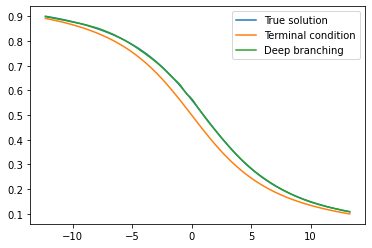

In [8]:
# n = 1/2
T = 2.
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=1/2, T=T, eps=1e-3, eps_graph=1e-1)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 22.168789863586426 seconds.


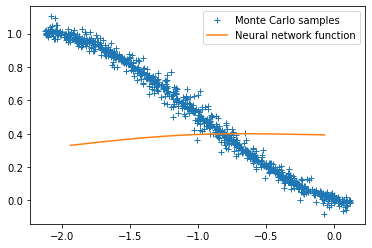

Patch 0: epoch 0 with loss 0.9226968288421631


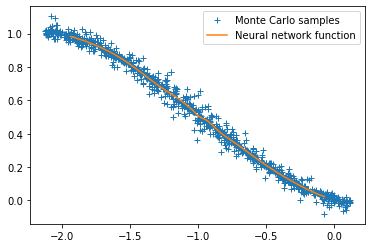

Patch 0: epoch 500 with loss 0.0008602126035839319


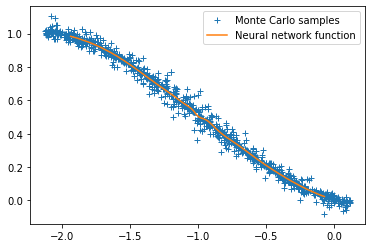

Patch 0: epoch 1000 with loss 0.0008567576878704131


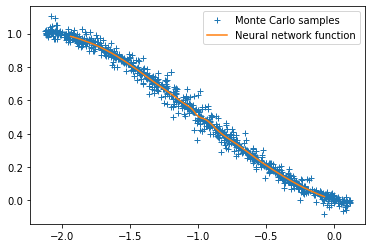

Patch 0: epoch 1500 with loss 0.0008555458625778556


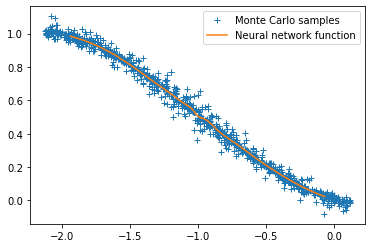

Patch 0: epoch 2000 with loss 0.0008551357313990593


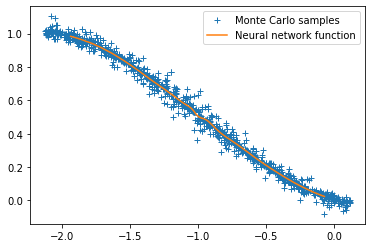

Patch 0: epoch 2500 with loss 0.0008553120424039662


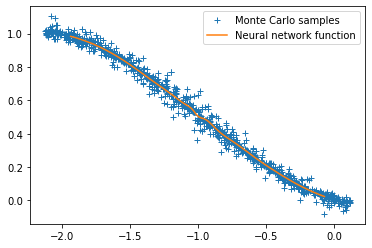

Patch 0: epoch 2999 with loss 0.000855015532579273
Patch 0: training of neural network with 3000 epochs take 10.197281837463379 seconds.
Time taken: 32 seconds; L1 error: 2.08E-03; L2 error: 8.58E-06; rel error: 6.24E-03.
fdb runtime: 0 seconds; total runtime: 32 seconds.




######## Summary for deep branching method
runtime:        32
fdb runtime:    0
total runtime:  32
mean L1 error:  2.08E-03
std L1 error:   0.00E+00
mean L2 error:  8.58E-06
std L2 error:   0.00E+00
mean rel error: 6.24E-03
std rel error:  0.00E+00


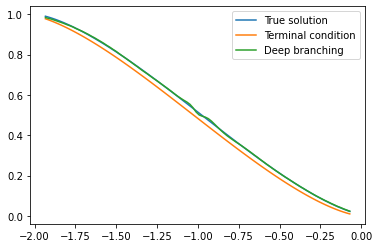

In [9]:
# n = 3
T = .1
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=3, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 21.13342261314392 seconds.


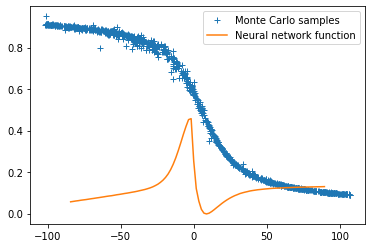

Patch 0: epoch 0 with loss 0.6478103399276733


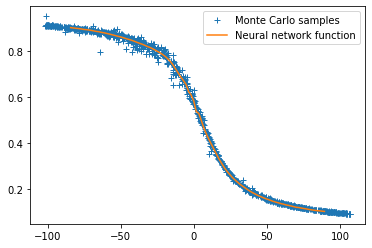

Patch 0: epoch 500 with loss 0.00010927494440693408


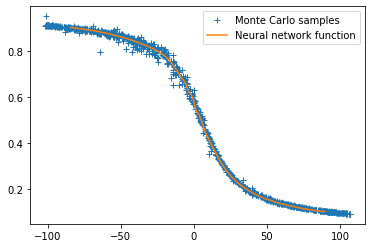

Patch 0: epoch 1000 with loss 0.00010975824989145622


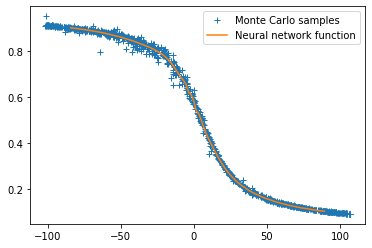

Patch 0: epoch 1500 with loss 0.00010692119394661859


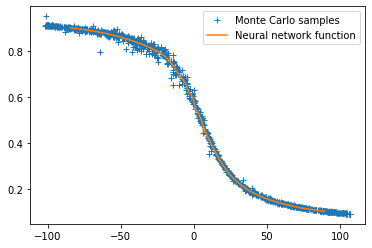

Patch 0: epoch 2000 with loss 0.00010690410999814048


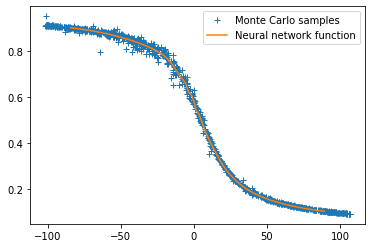

Patch 0: epoch 2500 with loss 0.00010704722808441147


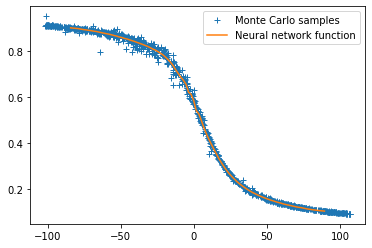

Patch 0: epoch 2999 with loss 0.00010684443259378895
Patch 0: training of neural network with 3000 epochs take 10.352335214614868 seconds.
Time taken: 31 seconds; L1 error: 1.77E-03; L2 error: 7.75E-06; rel error: 3.83E-03.
fdb runtime: 0 seconds; total runtime: 31 seconds.




######## Summary for deep branching method
runtime:        31
fdb runtime:    0
total runtime:  31
mean L1 error:  1.77E-03
std L1 error:   0.00E+00
mean L2 error:  7.75E-06
std L2 error:   0.00E+00
mean rel error: 3.83E-03
std rel error:  0.00E+00


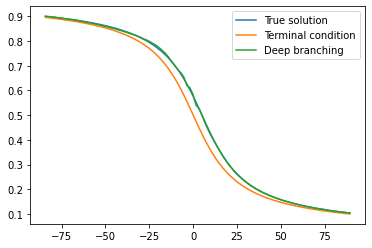

In [10]:
# n = 1/3
T = 10.
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=1/3, T=T, eps=1e-2, eps_graph=1e-1)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Burgers-type equation (Weinan)

$$
\partial_t u + \frac{1}{2} \partial_{xx} u + (u-\frac{3}{2}) \partial_x u = 0
$$
with
$$
\phi(x) = 1 - (1 + \exp(x))^{-1}
$$
admits the solution
$$
u(t,x) = 1 - (1 + \exp(-(T-t)+x))^{-1}.
$$

## T=1

In [11]:
# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return (y[0] - 3/2) * y[1]

def phi_example(x):
    return 1 - 1/(1 + torch.exp(x[0]))

def exact_example(t, x, T):
    return 1 - 1/(1 + np.exp(-(T-t) + x[0]))

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1.
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 42.68197011947632 seconds.


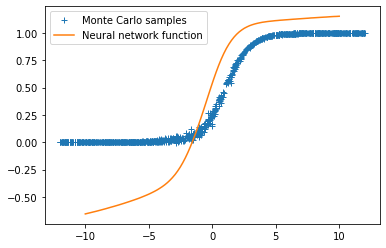

Patch 0: epoch 0 with loss 0.9138670563697815


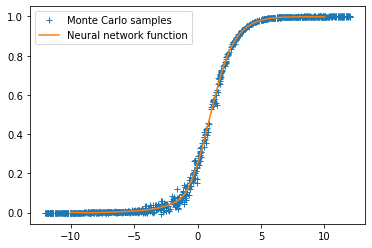

Patch 0: epoch 500 with loss 0.0001144586130976677


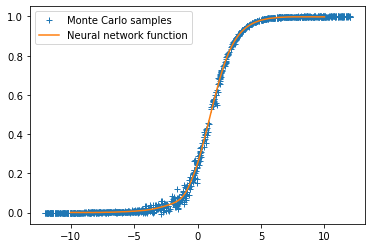

Patch 0: epoch 1000 with loss 0.0001138476436608471


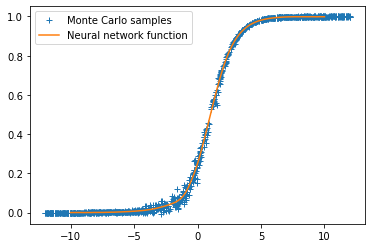

Patch 0: epoch 1500 with loss 0.00011351661669323221


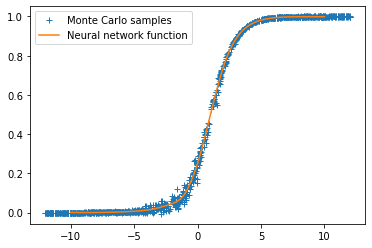

Patch 0: epoch 2000 with loss 0.00011351396824466065


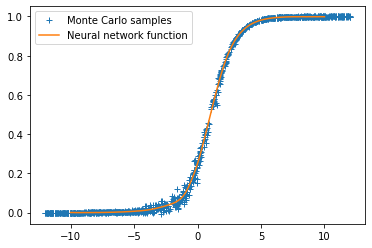

Patch 0: epoch 2500 with loss 0.00011359942436683923


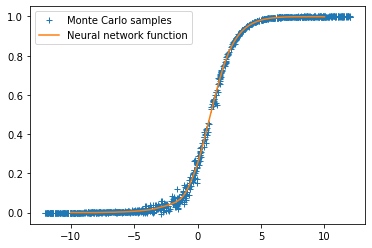

Patch 0: epoch 2999 with loss 0.00011361281940480694
Patch 0: training of neural network with 3000 epochs take 10.36350679397583 seconds.
Time taken: 53 seconds; L1 error: 3.93E-03; L2 error: 4.97E-05; rel error: 9.79E-01.
fdb runtime: 0 seconds; total runtime: 53 seconds.




######## Summary for deep branching method
runtime:        53
fdb runtime:    0
total runtime:  53
mean L1 error:  3.93E-03
std L1 error:   0.00E+00
mean L2 error:  4.97E-05
std L2 error:   0.00E+00
mean rel error: 9.79E-01
std rel error:  0.00E+00


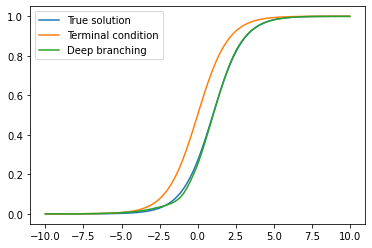

In [12]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="burger",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Kuramoto-Sivashinsky equation - example 1

In [59]:
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return y[0] * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        11
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    theta = -.5 * x[0] - (T - t)
    return (
        11
        + 15 * np.tanh(theta)
        - 15 * (np.tanh(theta))**2
        - 15 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .2
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 41.03263235092163 seconds.


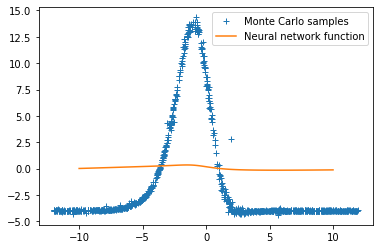

Patch 0: epoch 0 with loss 27.276123046875


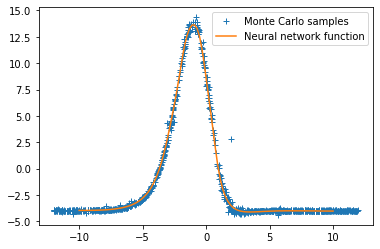

Patch 0: epoch 500 with loss 0.07269259542226791


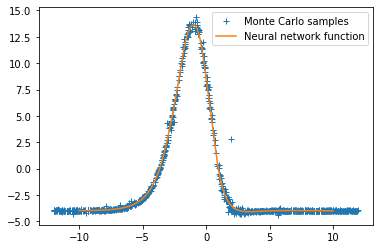

Patch 0: epoch 1000 with loss 0.0724671483039856


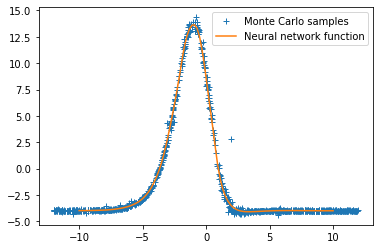

Patch 0: epoch 1500 with loss 0.07237877696752548


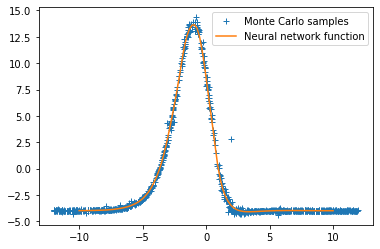

Patch 0: epoch 2000 with loss 0.07242176681756973


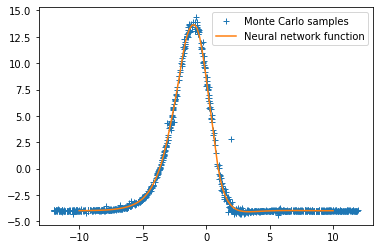

Patch 0: epoch 2500 with loss 0.07243341952562332


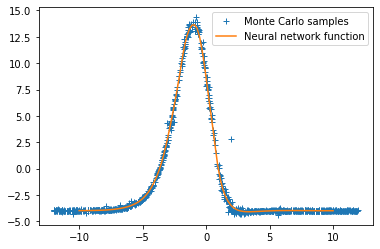

Patch 0: epoch 2999 with loss 0.07243332266807556
Patch 0: training of neural network with 3000 epochs take 10.408766508102417 seconds.
Time taken: 51 seconds; L1 error: 1.46E-01; L2 error: 8.13E-02; rel error: 4.81E-02.
fdb runtime: 0 seconds; total runtime: 51 seconds.




######## Summary for deep branching method
runtime:        51
fdb runtime:    0
total runtime:  51
mean L1 error:  1.46E-01
std L1 error:   0.00E+00
mean L2 error:  8.13E-02
std L2 error:   0.00E+00
mean rel error: 4.81E-02
std rel error:  0.00E+00


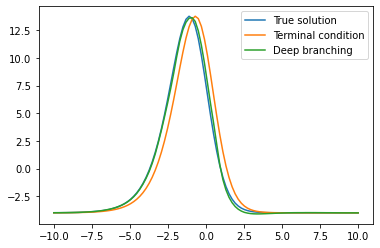

In [60]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky", nu=alpha,
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200, outlier_multiplier=100,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Kuramoto-Sivashinsky equation - example 3

In [20]:
alpha, beta, gamma = 1, .0, .5

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return y[0] * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0]
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * torch.tanh(theta) 
        + 120 * gamma * kappa**3 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0] + .1 * (T - t)
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * np.tanh(theta) 
        + 120 * gamma * kappa**3 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 33.03708624839783 seconds.


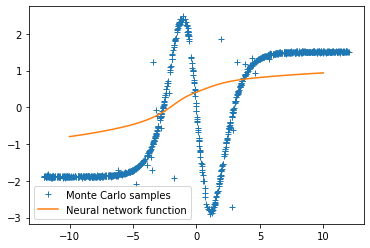

Patch 0: epoch 0 with loss 2.8186068534851074


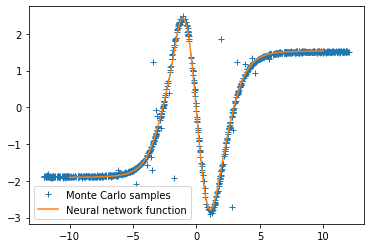

Patch 0: epoch 500 with loss 0.03875362500548363


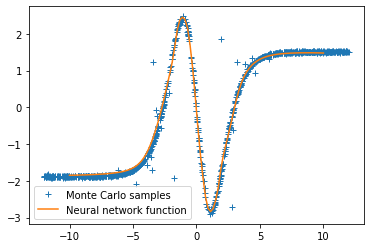

Patch 0: epoch 1000 with loss 0.03808048367500305


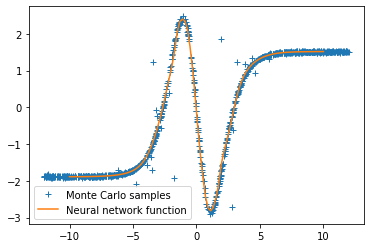

Patch 0: epoch 1500 with loss 0.03781341388821602


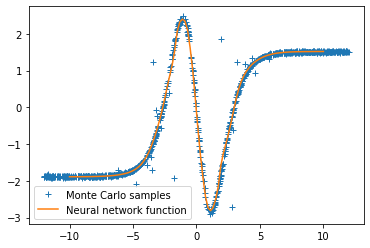

Patch 0: epoch 2000 with loss 0.03758622333407402


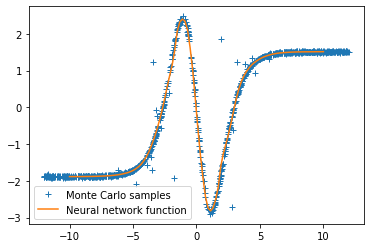

Patch 0: epoch 2500 with loss 0.037549834698438644


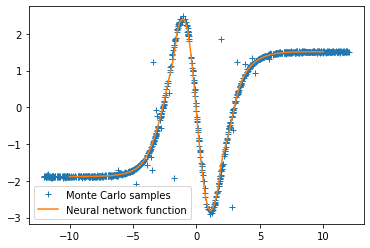

Patch 0: epoch 2999 with loss 0.037507783621549606
Patch 0: training of neural network with 3000 epochs take 10.575855493545532 seconds.
Time taken: 43 seconds; L1 error: 3.45E-02; L2 error: 4.65E-03; rel error: 7.45E-02.
fdb runtime: 0 seconds; total runtime: 44 seconds.




######## Summary for deep branching method
runtime:        43
fdb runtime:    0
total runtime:  44
mean L1 error:  3.45E-02
std L1 error:   0.00E+00
mean L2 error:  4.65E-03
std L2 error:   0.00E+00
mean rel error: 7.45E-02
std rel error:  0.00E+00


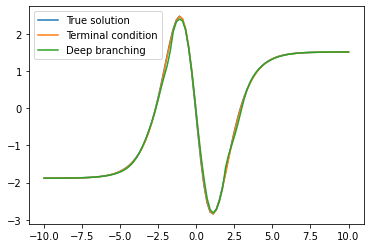

In [21]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky", nu=alpha,
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Gradient of 1-dimensional Allen-Cahn

In [36]:
# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.array([0, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> second deriv
    """
    return .5 * y[1] + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-x[0] / 2)

def exact_example(t, x, T):
    return 0.25 * (1 - np.tanh(-x[0]/2 + 3*(T-t)/4)**2)

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 10.396223068237305 seconds.


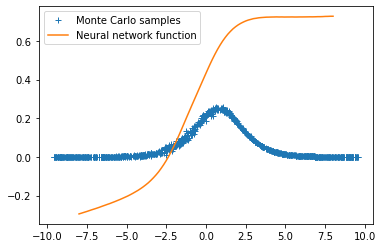

Patch 0: epoch 0 with loss 0.3921620547771454


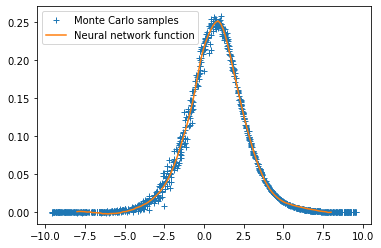

Patch 0: epoch 500 with loss 2.3328673705691472e-05


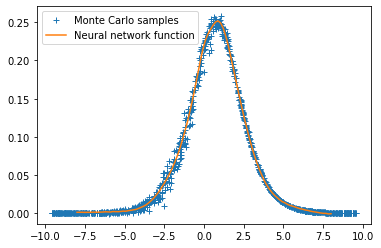

Patch 0: epoch 1000 with loss 2.2917927708476782e-05


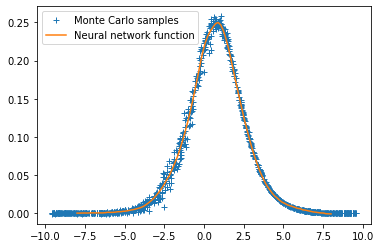

Patch 0: epoch 1500 with loss 2.197835965489503e-05


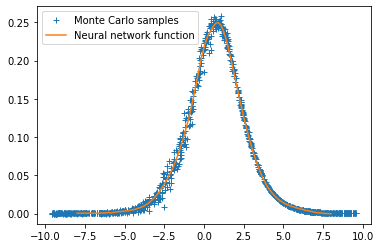

Patch 0: epoch 2000 with loss 2.1880918211536482e-05


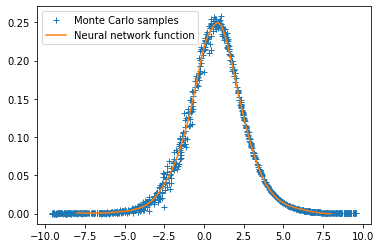

Patch 0: epoch 2500 with loss 2.1962900063954294e-05


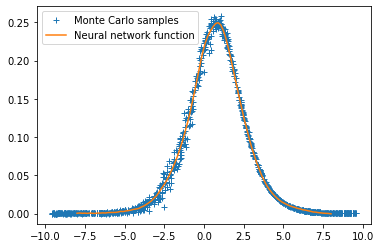

Patch 0: epoch 2999 with loss 2.1890014977543615e-05
Patch 0: training of neural network with 3000 epochs take 10.450318098068237 seconds.
Time taken: 21 seconds; L1 error: 9.34E-04; L2 error: 2.07E-06; rel error: 1.65E-01.
fdb runtime: 0 seconds; total runtime: 21 seconds.




######## Summary for deep branching method
runtime:        21
fdb runtime:    0
total runtime:  21
mean L1 error:  9.34E-04
std L1 error:   0.00E+00
mean L2 error:  2.07E-06
std L2 error:   0.00E+00
mean rel error: 1.65E-01
std rel error:  0.00E+00


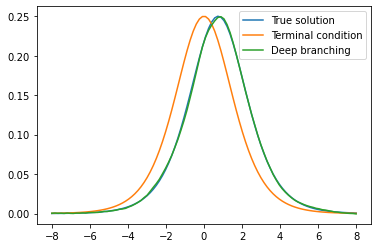

In [37]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn", code=[-2],
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)